# Coffee Type Prediction Model (User)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")

file_path = 'index_1.csv'
df = pd.read_csv(file_path)

# Convert to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

# Extract all features needed for both models
df['hour'] = df['datetime'].dt.hour
df['day_of_week_num'] = df['datetime'].dt.dayofweek # Monday=0, Sunday=6
df['month_num'] = df['datetime'].dt.month
df['day_of_week_name'] = df['datetime'].dt.day_name()

# Create a binary 'is_weekend' feature (1 if weekend, 0 if not)
df['is_weekend'] = df['day_of_week_name'].isin(['Saturday', 'Sunday']).astype(int)

## Feature Engineering

### 1. Customer Historical Preferences (for card customers)

In [2]:
card_df = df[df['cash_type'] == 'card'].dropna(subset=['card']).copy()

if len(card_df) > 0:
    # Calculate customer statistics
    customer_stats = card_df.groupby('card').agg({
        # Most frequent coffee purchase
        'coffee_name': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown', 
        # Number of visits
        'datetime': 'count',
        # Average spend per visit
        'money': 'mean'
    }).reset_index()
    customer_stats.columns = ['card', 'customer_favorite_coffee', 'customer_visit_count', 'customer_avg_spend']
    
    # Merge back to main dataframe
    df = df.merge(customer_stats, on='card', how='left')
    
    # Fill missing values for non-card customers
    df['customer_favorite_coffee'].fillna('Unknown', inplace=True)
    df['customer_visit_count'].fillna(0, inplace=True)
    df['customer_avg_spend'].fillna(df['money'].mean(), inplace=True)
else: # Actually, we have card customers in the dataset
    df['customer_favorite_coffee'] = 'Unknown'
    df['customer_visit_count'] = 0
    df['customer_avg_spend'] = df['money'].mean()

### 2. Time Series Features

In [3]:
df_sorted = df.sort_values(['card', 'datetime']).copy()
# Use shift to get previous purchase, avoiding current row
df_sorted['last_coffee'] = df_sorted.groupby('card')['coffee_name'].shift(1)
df_sorted['last_coffee'].fillna('Unknown', inplace=True)
df = df_sorted.copy()

### 3. Cyclical Time Features (sin/cos encoding)

In [4]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week_num'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week_num'] / 7)

### 4. Time-based Price Features 

using historical average, not current coffee price

In [5]:
# Calculate average price by hour (not by coffee type) to avoid leakage
df['avg_price_by_hour'] = df.groupby('hour')['money'].transform('mean')
df['avg_price_by_month'] = df.groupby('month_num')['money'].transform('mean')

# Interaction Features
df['hour_weekend'] = df['hour'] * df['is_weekend']
df['month_weekend'] = df['month_num'] * df['is_weekend']
# Remove customer_preference_match as it uses target variable


## Prepare Features

In [6]:
# Prepare features
numeric_features = [
    'hour', 'day_of_week_num', 'month_num', 'is_weekend', # Time features
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
    'day_of_week_sin', 'day_of_week_cos', # Cyclical time features
    'customer_visit_count', 'customer_avg_spend', # Customer features
    'avg_price_by_hour', 'avg_price_by_month',  # Historical averages, not current transaction
    'hour_weekend', 'month_weekend' # Interaction features
]

categorical_features = ['customer_favorite_coffee', 'last_coffee'] # str

# Encode categorical features
le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le
    numeric_features.append(col + '_encoded')

# Prepare X and y
X = df[numeric_features].fillna(0)
y = df['coffee_name']

print(f"Total features: {len(numeric_features)}")
print(f"Feature list: {numeric_features[:10]}... (showing first 10)")

Total features: 18
Feature list: ['hour', 'day_of_week_num', 'month_num', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']... (showing first 10)


## Balance Datasets

In [7]:
classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))

print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass weights calculated for balanced training")


Class distribution:
coffee_name
Americano with Milk    824
Latte                  782
Americano              578
Cappuccino             501
Cortado                292
Hot Chocolate          282
Cocoa                  243
Espresso               134
Name: count, dtype: int64

Class weights calculated for balanced training


## (Model) Decision Tree

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Decision Tree (Baseline)
print("\n" + "=" * 70)
print("Baseline Model: Decision Tree")
print("=" * 70)

dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"\nDecision Tree Accuracy: {accuracy_dt:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Training set: 2545 samples
Test set: 1091 samples

Baseline Model: Decision Tree

Decision Tree Accuracy: 74.52%

Classification Report:
                     precision    recall  f1-score   support

          Americano       0.66      0.87      0.75       173
Americano with Milk       0.77      0.81      0.79       247
         Cappuccino       0.80      0.66      0.73       150
              Cocoa       0.62      0.62      0.62        73
            Cortado       0.83      0.72      0.77        88
           Espresso       0.89      0.62      0.74        40
      Hot Chocolate       0.75      0.56      0.64        85
              Latte       0.77      0.78      0.78       235

           accuracy                           0.75      1091
          macro avg       0.76      0.70      0.72      1091
       weighted avg       0.75      0.75      0.74      1091



## (Model) Random Forest

In [9]:
# Random Forest
print("\n" + "=" * 70)
print("Improved Model 1: Random Forest")
print("=" * 70)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\nRandom Forest Accuracy: {accuracy_rf:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))


Improved Model 1: Random Forest

Random Forest Accuracy: 73.33%

Classification Report:
                     precision    recall  f1-score   support

          Americano       0.67      0.87      0.76       173
Americano with Milk       0.79      0.73      0.76       247
         Cappuccino       0.70      0.66      0.68       150
              Cocoa       0.66      0.64      0.65        73
            Cortado       0.79      0.70      0.75        88
           Espresso       0.64      0.68      0.66        40
      Hot Chocolate       0.69      0.58      0.63        85
              Latte       0.79      0.79      0.79       235

           accuracy                           0.73      1091
          macro avg       0.72      0.71      0.71      1091
       weighted avg       0.74      0.73      0.73      1091



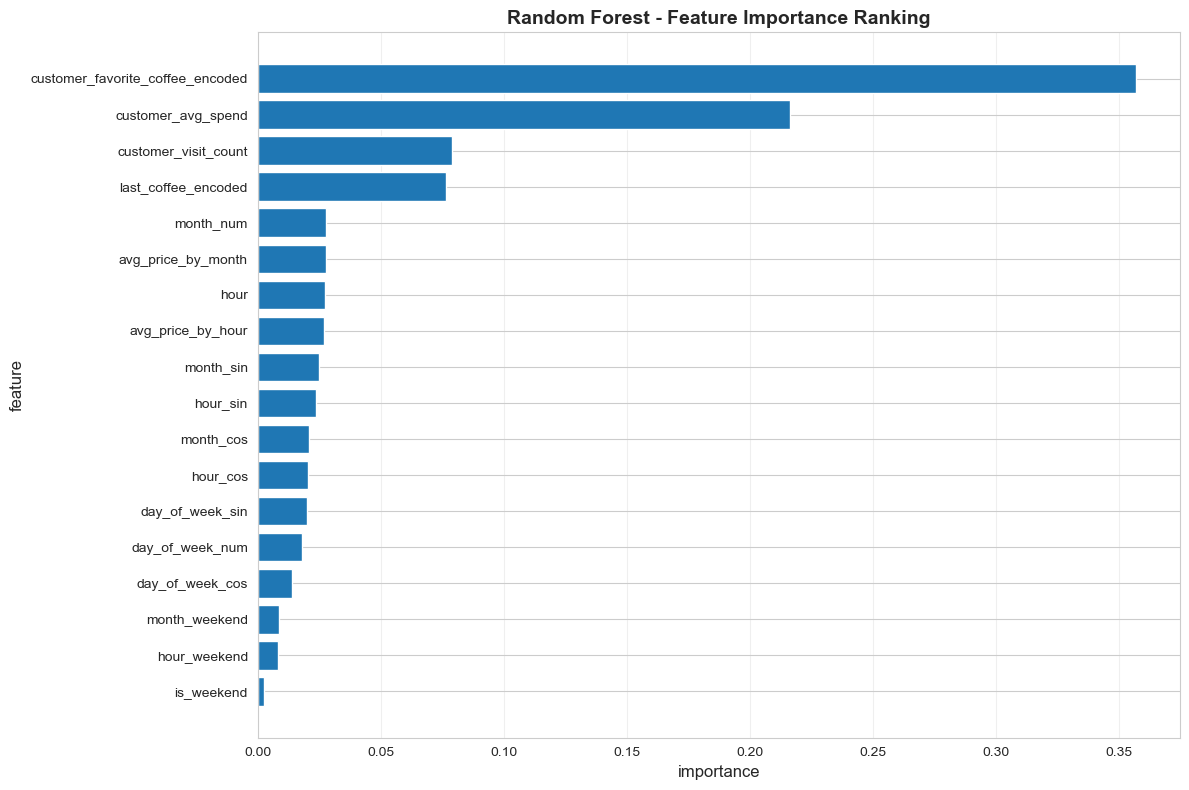

                         feature  importance
customer_favorite_coffee_encoded    0.356887
              customer_avg_spend    0.216256
            customer_visit_count    0.079033
             last_coffee_encoded    0.076698
                       month_num    0.027899
              avg_price_by_month    0.027603
                            hour    0.027514
               avg_price_by_hour    0.026873
                       month_sin    0.024921
                        hour_sin    0.023744


In [11]:
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'], align='center')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('importance', fontsize=12)
plt.ylabel('feature', fontsize=12)
plt.title('Random Forest - Feature Importance Ranking', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # 最重要的特征在顶部
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(feature_importance.head(10).to_string(index=False))